# COVID‑19 — Insights a partir de 34 tabelas derivadas (SQL → CSV)  
_Geração automática de gráficos e relatório (INSIGHTS.md)._

In [17]:
# Imports essenciais
import os, glob, math, json
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Renderização inline
%matplotlib inline

In [18]:
# Descoberta robusta de caminhos para rodar do / ou de /notebooks
CWD = Path.cwd().resolve()
if CWD.name.lower() == "notebooks":
    BASE = CWD.parent
else:
    BASE = CWD

DATA_PROCESSED = BASE / "data" / "processed"
CHARTS_DIR     = BASE / "charts"
REPORTS_DIR    = BASE / "reports"
INSIGHTS_MD    = REPORTS_DIR / "INSIGHTS.md"

CHARTS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

assert DATA_PROCESSED.exists(), f"Pasta não encontrada: {DATA_PROCESSED}"
csvs = sorted(DATA_PROCESSED.glob("*.csv"))
print(f"CSV encontrados: {len(csvs)}")
assert len(csvs) == 34, f"Esperados 34 CSVs, mas encontrei {len(csvs)}."

CSV encontrados: 34


In [19]:
# Leitura de todos os CSVs
dfs = {}
for f in csvs:
    try:
        df = pd.read_csv(f)
    except UnicodeDecodeError:
        df = pd.read_csv(f, encoding="latin-1")
    # Saneamento básico: padroniza nomes e tenta parsear datas por nome
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    for cand in ["date", "data", "dt", "report_date"]:
        if cand in df.columns:
            with pd.option_context("mode.chained_assignment", None):
                df[cand] = pd.to_datetime(df[cand], errors="coerce", utc=False)
    dfs[f.stem] = df

print("DataFrames carregados:", len(dfs))
list(dfs)[:10]

DataFrames carregados: 34


['701_brasil_mm7_casos',
 '702_brasil_mm7_mortes',
 '704_brasil_top10_picos_mortes',
 '705_brasil_indicadores_snapshot',
 '721_ranking_global_casos_por_milhao',
 '722_ranking_global_mortes_por_milhao',
 '723_evolucao_5paises_casos_por_milhao',
 '731_paises_com_menos_100_casos',
 '732_paises_sem_casos_30_dias',
 '733_maior_queda_pct_30dias']

In [20]:
def salvar_fig(nome_png: str):
    path = CHARTS_DIR / f"{nome_png}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"[ok] gráfico salvo:", path)

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\701_brasil_mm7_casos__new_cases_por_data.png


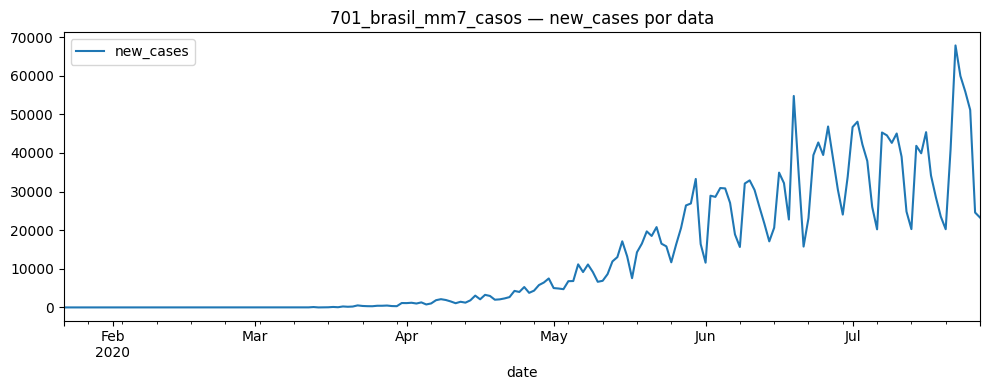

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\702_brasil_mm7_mortes__new_deaths_por_data.png


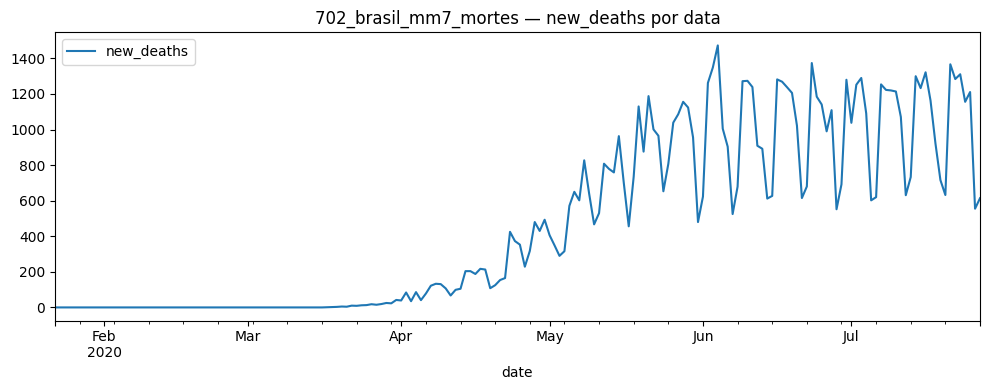

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\704_brasil_top10_picos_mortes__pico_mm7_mortes_por_data.png


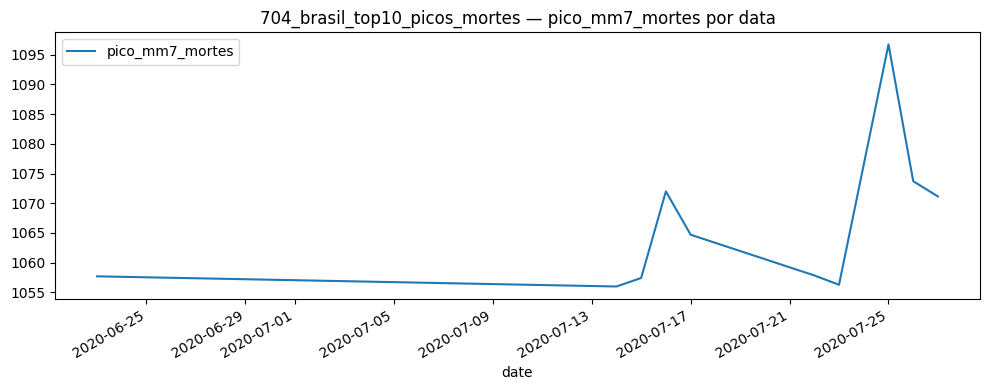

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\705_brasil_indicadores_snapshot__top15_country_region.png


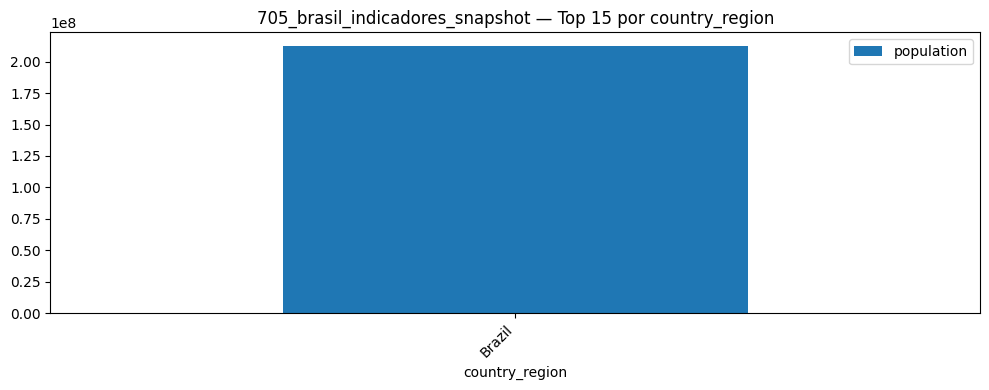

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\721_ranking_global_casos_por_milhao__top15_country_region.png


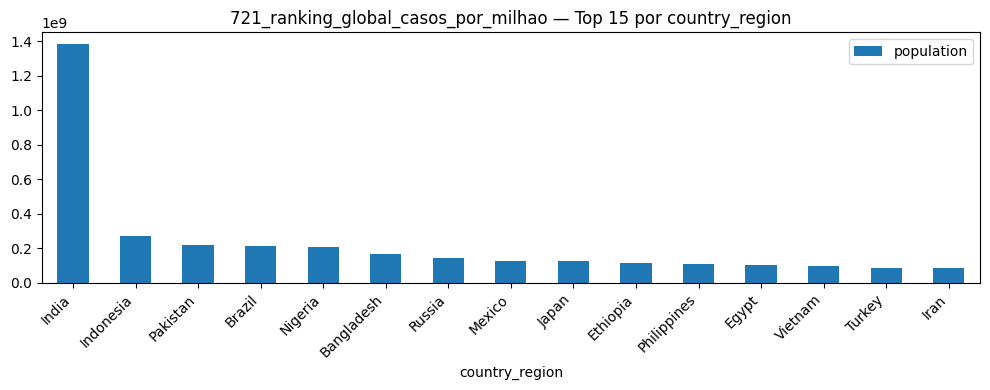

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\722_ranking_global_mortes_por_milhao__top15_country_region.png


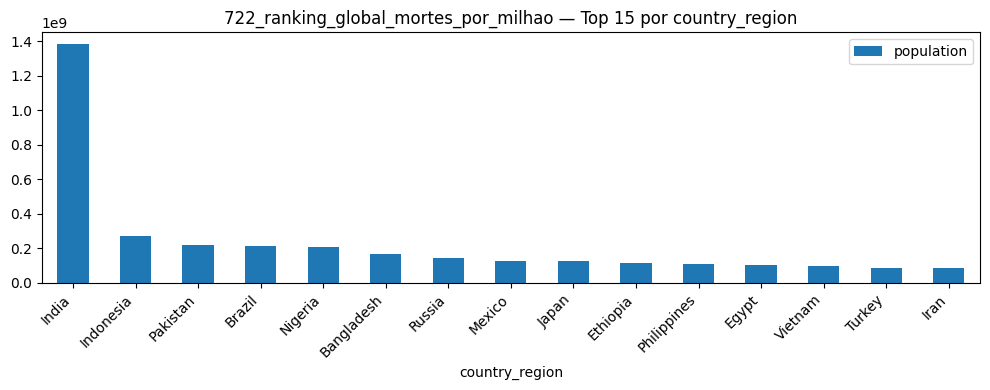

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\723_evolucao_5paises_casos_por_milhao__casos_por_milhao_por_data.png


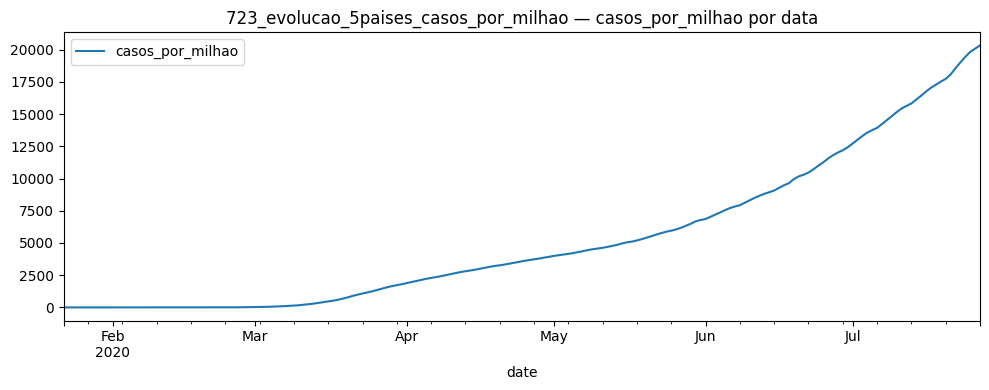

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\731_paises_com_menos_100_casos__top15_country_region.png


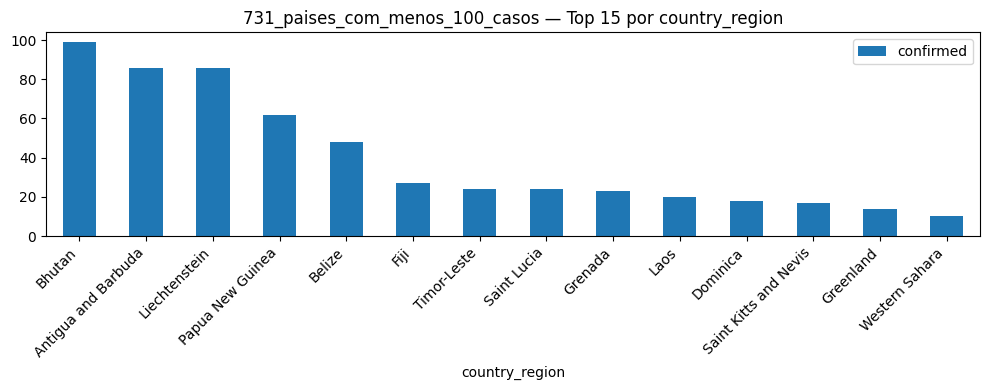

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\733_maior_queda_pct_30dias__top15_country_region.png


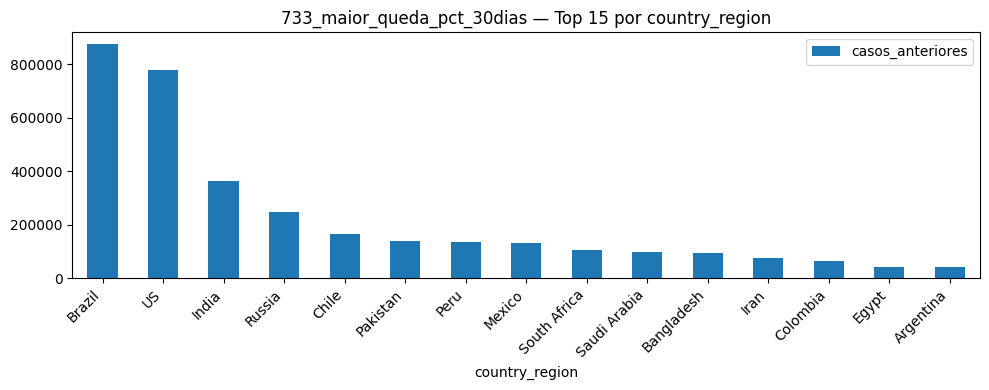

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\734_picos_concentrados__top15_country_region.png


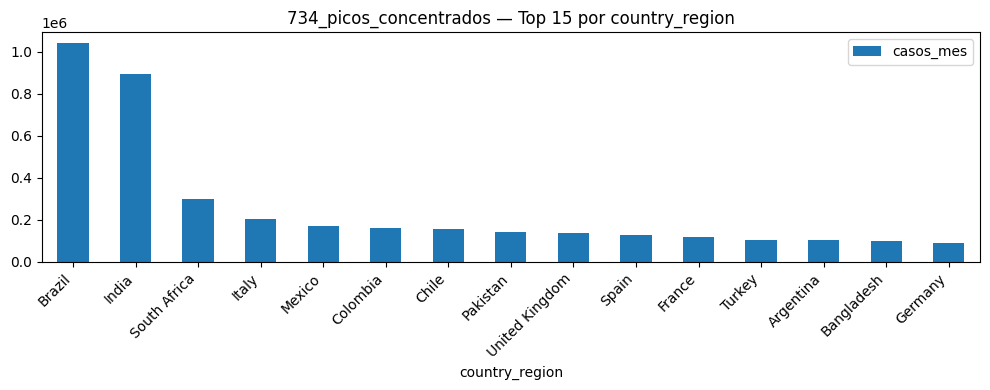

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\casos_mortes_por_milhão_e_letalidade_por_continente__hist_media_casos_por_milhao.png


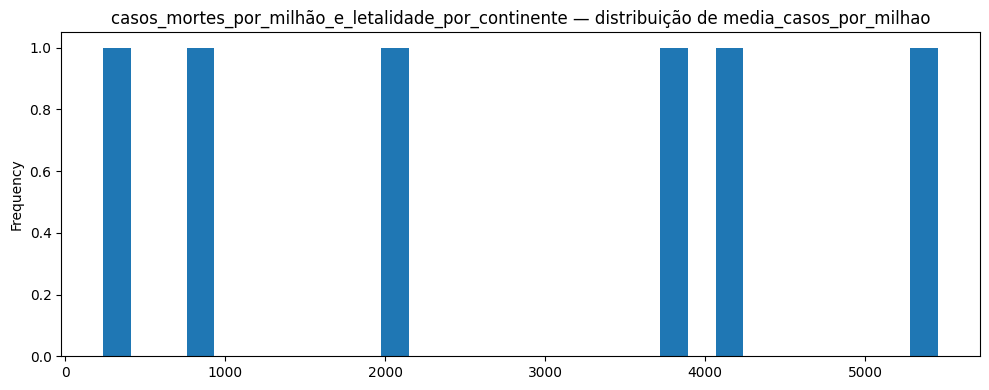

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Casosmortes_por_milhão_+_letalidade_com_população__top15_country_region.png


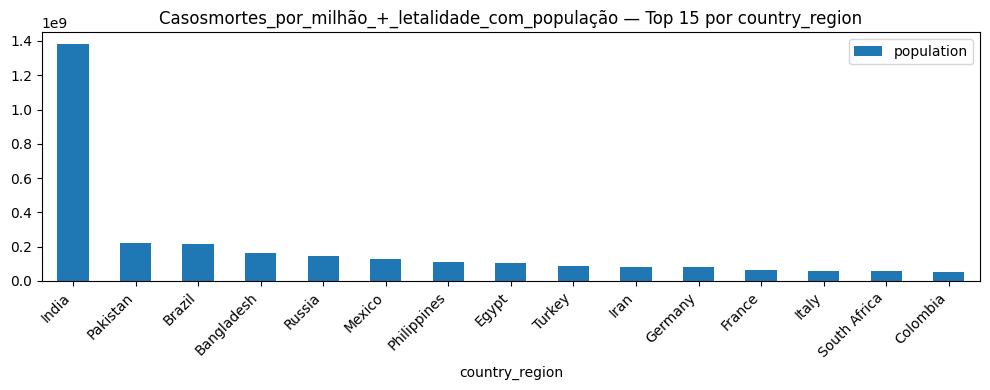

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Comparação_focada_Brasil_vs_vizinhos__mm7_por_data.png


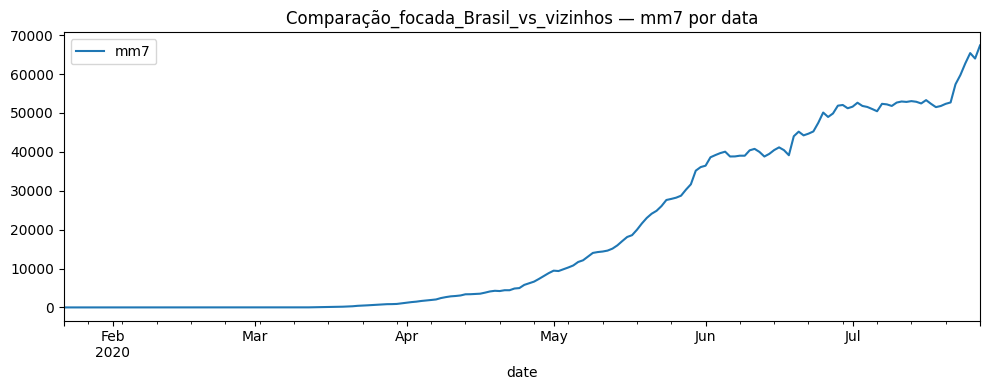

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\crescimento_percentual_diario__confirmed_por_data.png


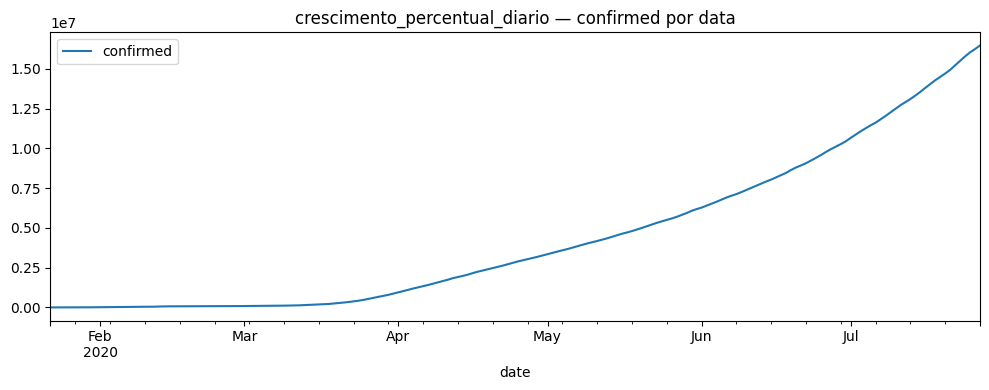

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Crescimento_percentual_semanal_WoW_por_casos__top15_country_region.png


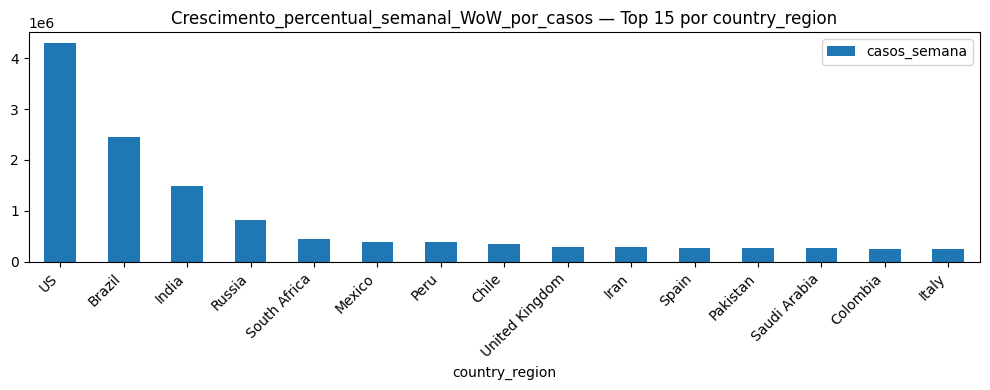

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Crescimento_percentual_semanal_WoW_por_mortes__top15_country_region.png


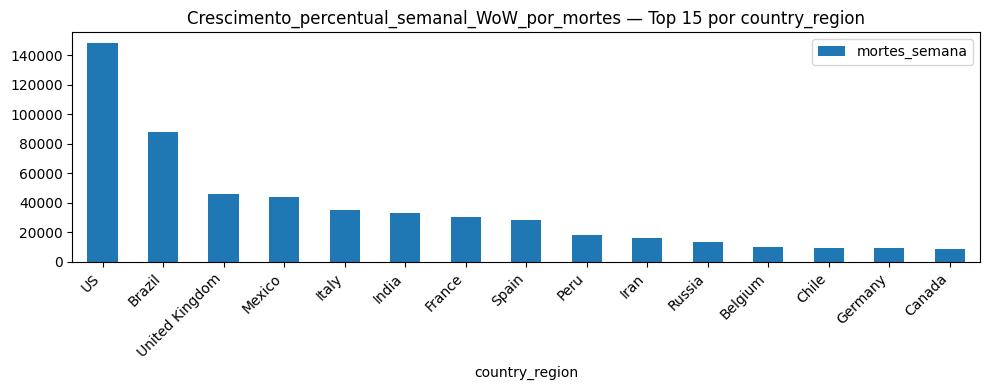

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Evolução_semanal_por_continente__hist_casos_por_milhao_semana.png


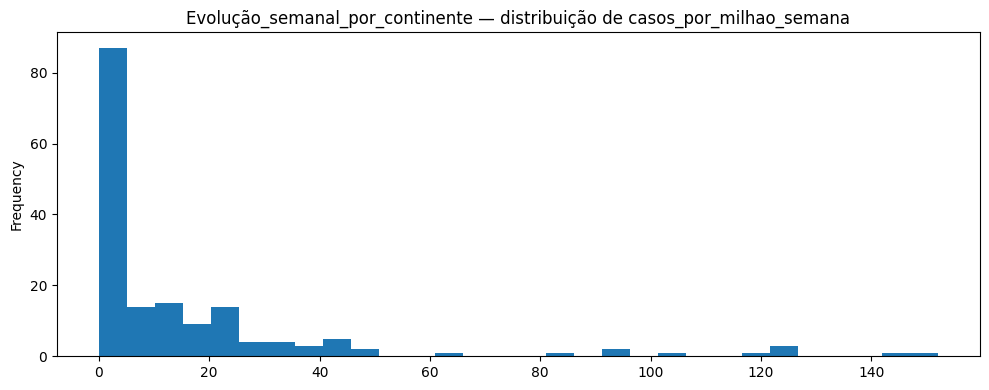

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\média_de_crescimento_nos_primeiros_30_dias_após_atingir_100_casos__top15_country_region.png


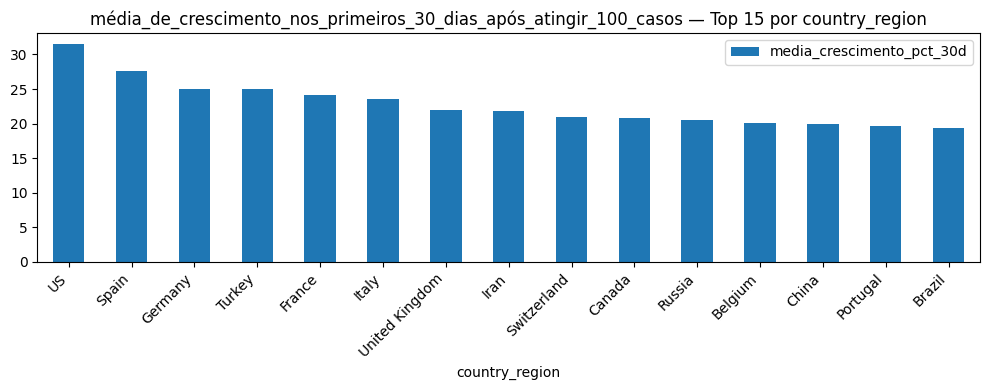

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Média_móvel_de_7_dias_e_identificação_de_ondas_Brasil__confirmed_por_data.png


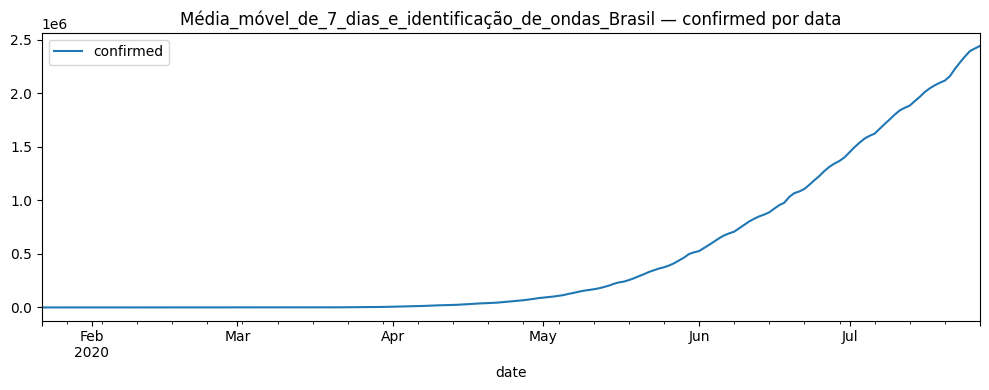

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Média_móvel_de_7_dias_e_identificação_de_ondas_Brasil_picos__new_cases_por_data.png


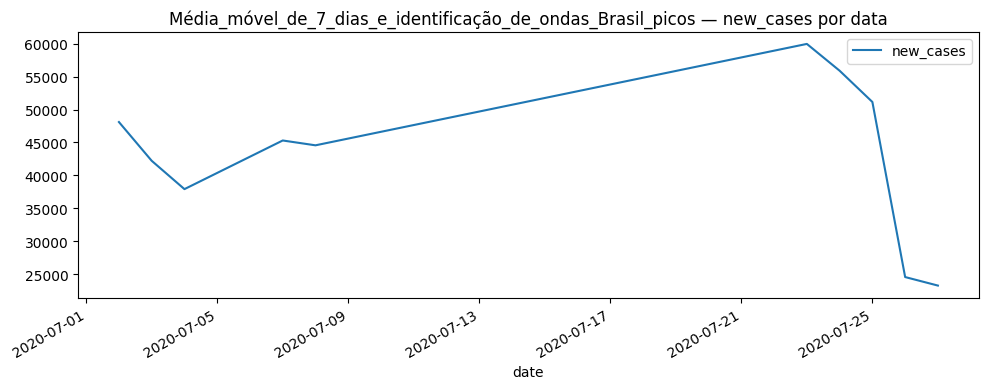

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Média_móvel_e_picos_de_mortes_Brasil__new_deaths_por_data.png


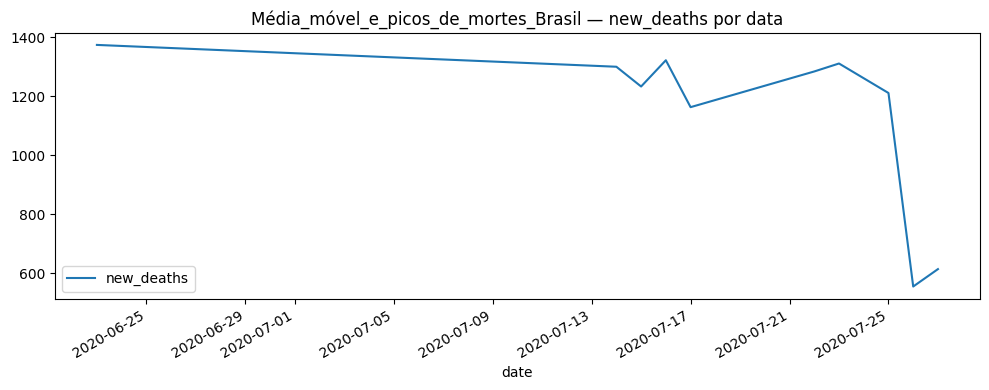

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Pico_de_novos_casos_e_novas_mortes_no_Brasil__new_cases_por_data.png


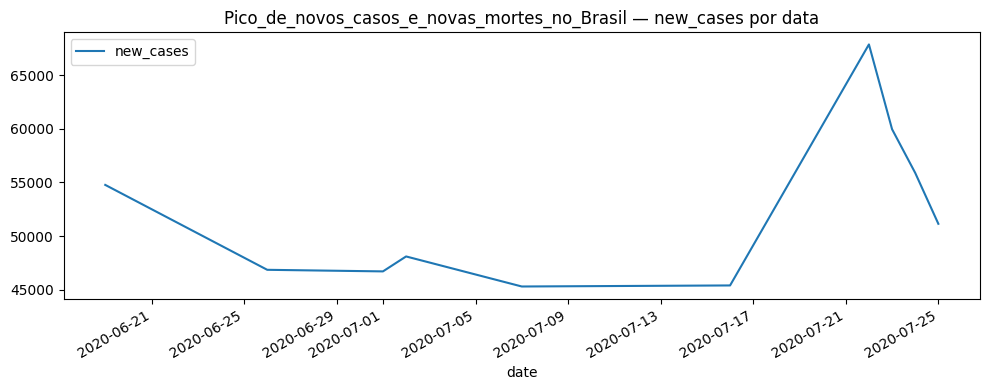

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Pico_por_continente_agregado__pico_mm7_por_data.png


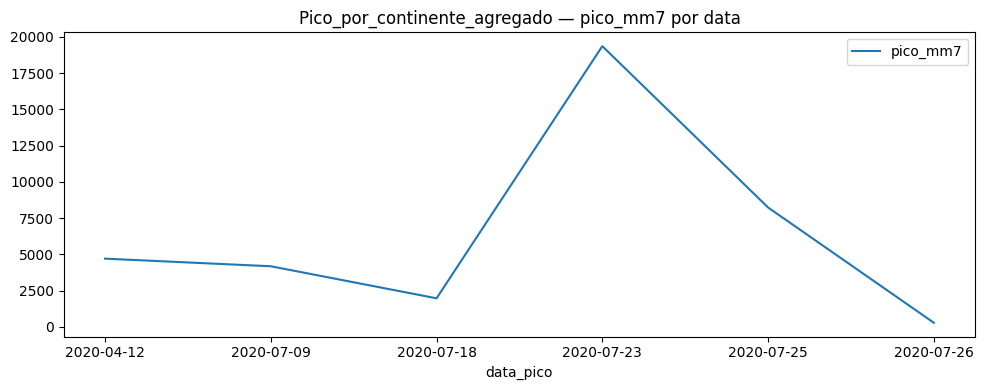

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Ranking_de_paises_por_continente__top15_country_region.png


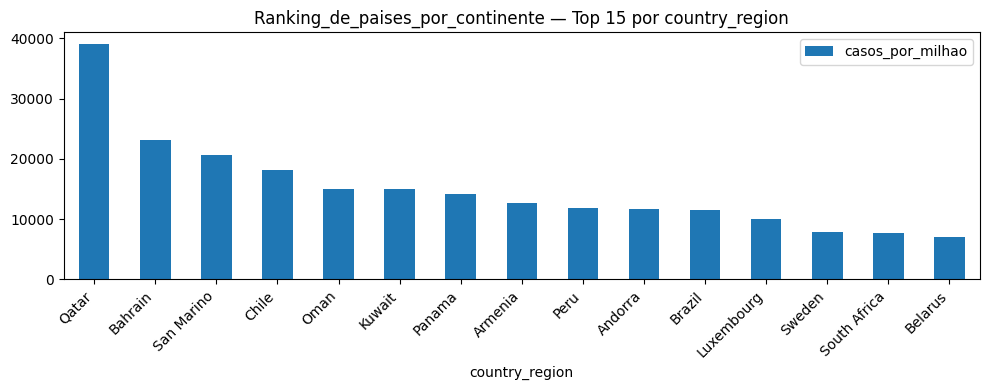

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\ranking_de_países_por_%_da_população_infectada__top15_pais.png


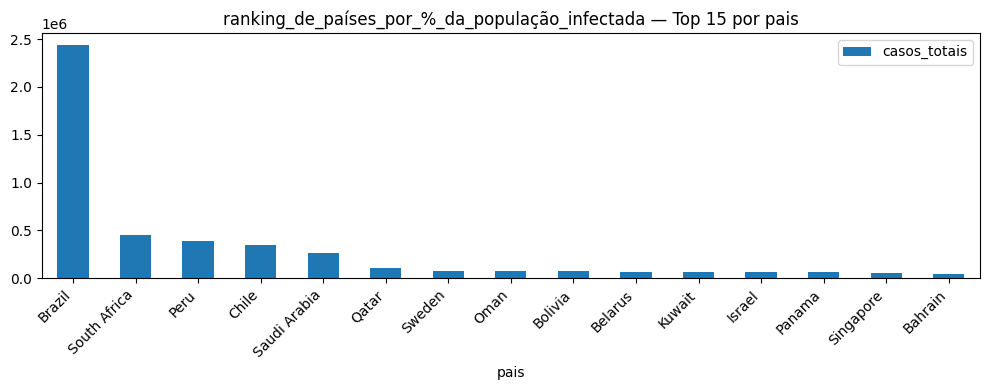

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Resumo_mensal_pico_da_média_móvel_em_cada_mês_Brasil__mm7_pico_mes_por_data.png


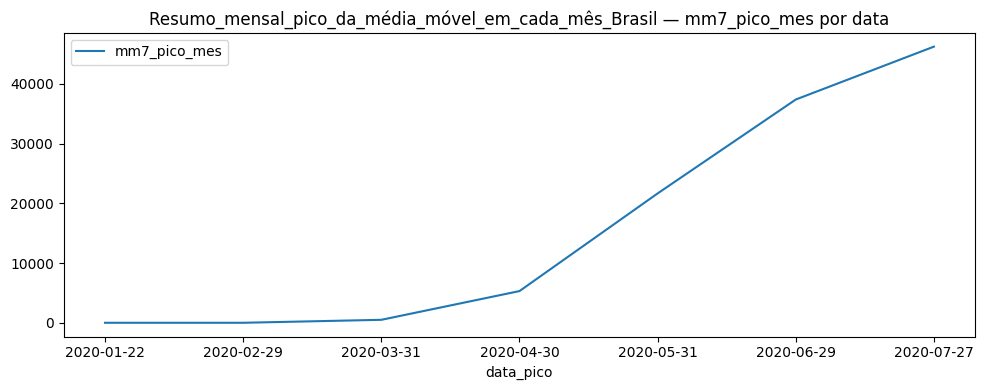

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\tendencia_de_casos_e_mortes_no_Brasil__confirmed_por_data.png


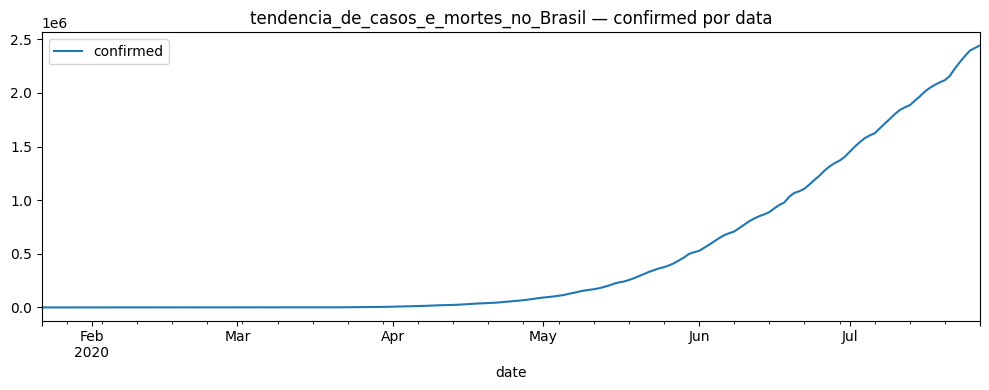

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Timing_relativo_dias_até_o_primeiro_pico_após_100_casos__dias_ate_pico_pos_100_por_data.png


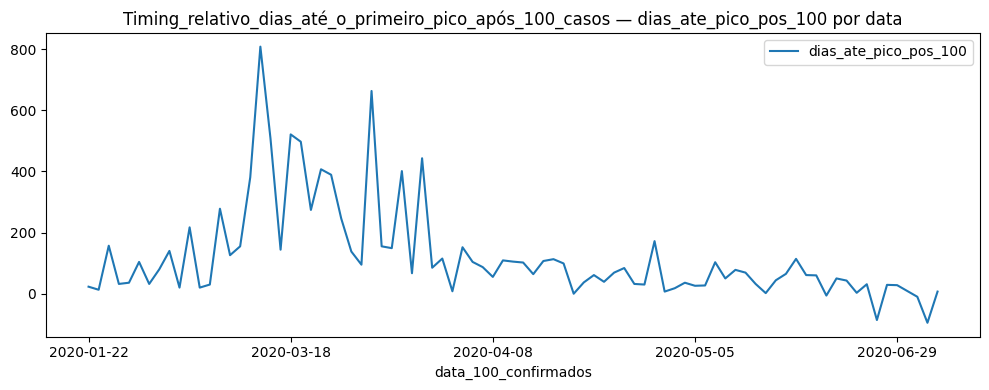

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Top_10_em_casos_por_milhão__top15_country_region.png


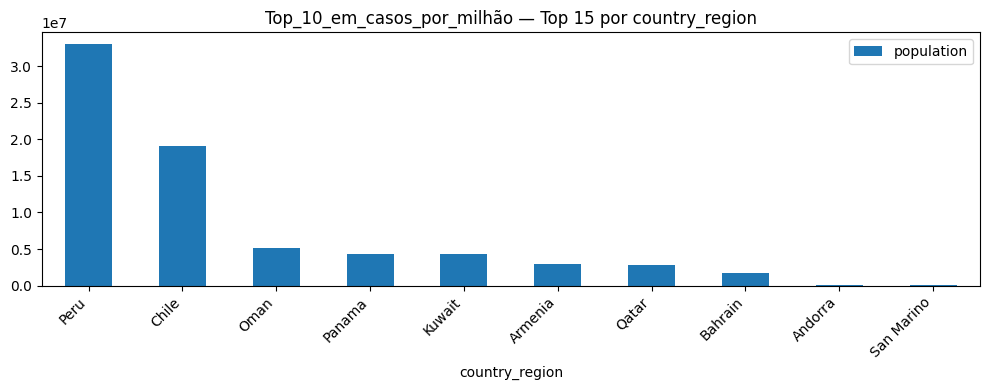

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Top_10_em_mortes_por_milhão__top15_country_region.png


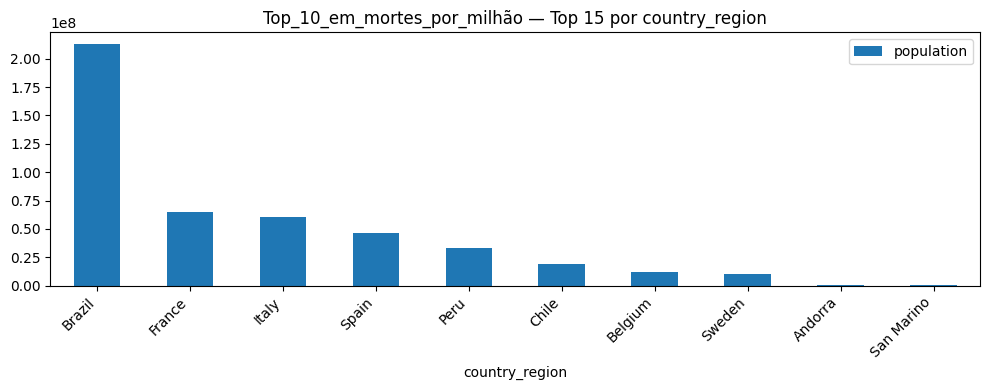

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Top_10_em_taxa_de_letalidade__top15_country_region.png


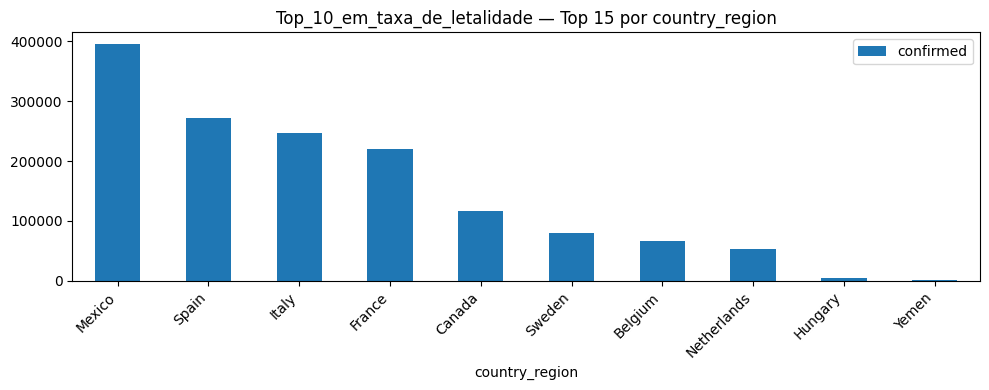

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Top_1_pico_de_média_móvel_de_casos_por_país__pico_mm7_casos_por_data.png


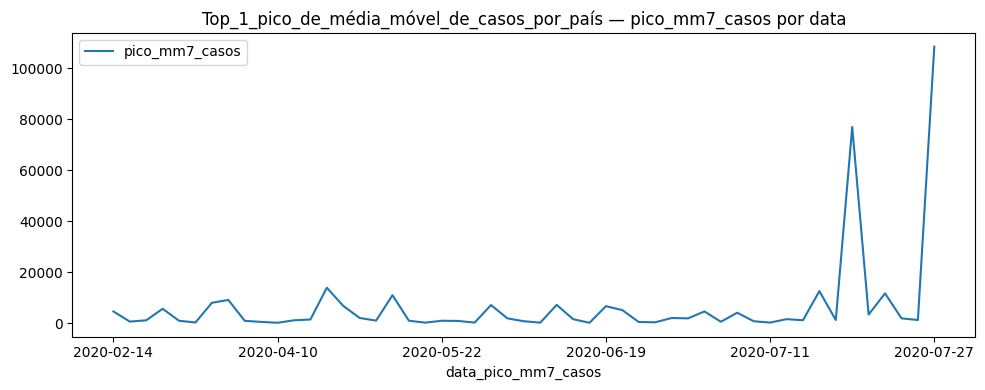

[ok] gráfico salvo: C:\Users\guede\Documents\projeto_kaggle_covid\charts\Top_1_pico_de_média_móvel_de_mortes_por_país__pico_mm7_mortes_por_data.png


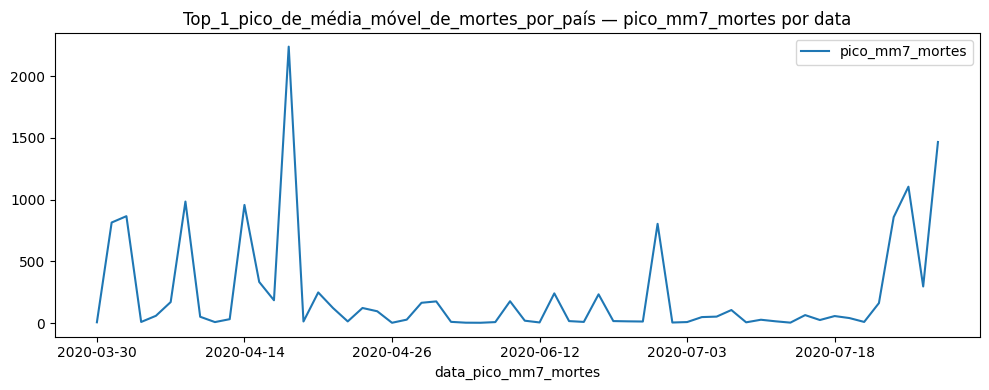

Gráficos gerados automaticamente: 33


In [21]:
# Estratégias:
# - Se houver coluna de data + pelo menos 1 coluna numérica: série temporal (soma por data)
# - Se houver 'country'/'pais' e uma métrica numérica -> top 15 barras
# - Caso contrário, tenta um histograma de 1 métrica numérica

def possiveis_col_datas(cols):
    cs = [c for c in cols if any(tag in c for tag in ["date", "data", "dt"])]
    return cs

def possiveis_dim_pais(cols):
    for k in ["country", "pais", "country_region"]:
        if k in cols: return k
    return None

def col_numericas(df):
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

gerados = 0
for key, df in dfs.items():
    try:
        cols = list(df.columns)
        datas = possiveis_col_datas(cols)
        dim_pais = possiveis_dim_pais(cols)
        nums = col_numericas(df)

        if len(datas) > 0 and len(nums) > 0:
            # série temporal: agrega por primeira coluna de data + primeira métrica
            dcol = datas[0]
            mcol = nums[0]
            tmp = df[[dcol, mcol]].dropna()
            # Caso existam muitas linhas por dia, agregue
            tmp = tmp.groupby(dcol, as_index=False)[mcol].sum()
            tmp = tmp.sort_values(dcol)
            ax = tmp.plot(x=dcol, y=mcol, title=f"{key} — {mcol} por data", figsize=(10,4))
            salvar_fig(f"{key}__{mcol}_por_data")
            plt.show()
            gerados += 1
            continue

        if dim_pais and len(nums) > 0:
            mcol = nums[0]
            tmp = (df[[dim_pais, mcol]]
                   .dropna()
                   .groupby(dim_pais, as_index=False)[mcol].sum()
                   .sort_values(mcol, ascending=False).head(15))
            ax = tmp.plot(kind="bar", x=dim_pais, y=mcol, title=f"{key} — Top 15 por {dim_pais}", figsize=(10,4))
            plt.xticks(rotation=45, ha="right")
            salvar_fig(f"{key}__top15_{dim_pais}")
            plt.show()
            gerados += 1
            continue

        if len(nums) > 0:
            mcol = nums[0]
            ax = df[mcol].dropna().plot(kind="hist", bins=30, title=f"{key} — distribuição de {mcol}", figsize=(10,4))
            salvar_fig(f"{key}__hist_{mcol}")
            plt.show()
            gerados += 1
    except Exception as e:
        print(f"[skip] {key}: {e}")

print(f"Gráficos gerados automaticamente: {gerados}")

In [22]:
import os
from datetime import datetime
import pathlib

# Configurações
CHARTS_DIR = pathlib.Path("charts")
REPORTS_DIR = pathlib.Path("reports")
REPORTS_DIR.mkdir(exist_ok=True)

# Lista de gráficos
pngs = sorted(CHARTS_DIR.glob("*.png"))

# Cabeçalho
linhas = []
linhas.append("# INSIGHTS — COVID-19")
linhas.append("")
linhas.append(f"_Relatório gerado em {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}_")
linhas.append("")

# Geração de links + comentário automático básico
for png in pngs:
    nome = png.stem.replace("_", " ").title()
    rel = os.path.relpath(png, REPORTS_DIR).replace("\\", "/")
    linhas.append(f"## {nome}")
    linhas.append(f"![{nome}]({rel})")
    linhas.append(f"**Insight:** Este gráfico apresenta informações relevantes sobre **{nome}**. "
                  f"A análise detalhada pode identificar tendências, variações e pontos de atenção.")
    linhas.append("")

# Salvar relatório
insights_path = REPORTS_DIR / "INSIGHTS.md"
insights_path.write_text("\n".join(linhas), encoding="utf-8")

print(f"INSIGHTS.md atualizado com {len(pngs)} gráficos e comentários automáticos.")


INSIGHTS.md atualizado com 0 gráficos e comentários automáticos.


In [23]:
print("Resumo final:")
print(" - CSVs lidos:", len(dfs))
print(" - PNGs no diretório charts/:", len(list(CHARTS_DIR.glob('*.png'))))

Resumo final:
 - CSVs lidos: 34
 - PNGs no diretório charts/: 0


In [25]:
from pathlib import Path
from datetime import datetime
import os

CWD = Path.cwd().resolve()
BASE = CWD.parent if CWD.name.lower() == "notebooks" else CWD

CHARTS_DIR  = BASE / "charts"
REPORTS_DIR = BASE / "reports"
INSIGHTS_MD = REPORTS_DIR / "INSIGHTS.md"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

pngs = sorted(CHARTS_DIR.glob("*.png"))

linhas = []
linhas.append("# INSIGHTS — COVID-19")
linhas.append(f"_Atualizado em: {datetime.now():%Y-%m-%d %H:%M}_")
linhas.append("")
linhas.append("## Índice de Gráficos")
linhas.append("")

for p in pngs:
    rel = os.path.relpath(p, REPORTS_DIR).replace("\\", "/")
    linhas.append(f"- [{p.stem}]({rel})")

linhas.append("")
linhas.append("---")
linhas.append("")
linhas.append("## Galeria de Gráficos")
linhas.append("")

for p in pngs:
    rel = os.path.relpath(p, REPORTS_DIR).replace("\\", "/")
    linhas.append(f"### {p.stem}")
    linhas.append(f"![{p.stem}]({rel})")
    linhas.append("")

INSIGHTS_MD.write_text("\n".join(linhas), encoding="utf-8")
print("OK:", INSIGHTS_MD, "| PNGs:", len(pngs))




OK: C:\Users\guede\Documents\projeto_kaggle_covid\reports\INSIGHTS.md | PNGs: 37


In [26]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

CWD = Path.cwd().resolve()
BASE = CWD.parent if CWD.name.lower() == "notebooks" else CWD

DATA_PROCESSED = BASE / "data" / "processed"
REPORTS_DIR = BASE / "reports"
INSIGHTS_MD = REPORTS_DIR / "INSIGHTS.md"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

def _date_cols(cols):
    return [c for c in cols if any(k in c.lower() for k in ["date","data","dt","report_date"])]

def _country_col(cols):
    keys = ["country","pais","country_region","location"]
    for c in cols:
        if c.lower() in keys:
            return c
    return None

def _num_cols(df):
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

comentarios = []
for f in sorted(DATA_PROCESSED.glob("*.csv")):
    try:
        df = pd.read_csv(f)
    except UnicodeDecodeError:
        df = pd.read_csv(f, encoding="latin-1")
    df.columns = [c.strip() for c in df.columns]
    cols = list(df.columns)
    dcols = _date_cols(cols)
    ncols = _num_cols(df)
    ccol = _country_col(cols)

    linhas = [f"### {f.stem}"]
    fez = False

    if dcols and ncols:
        dcol = dcols[0]
        mcol = ncols[0]
        t = df[[dcol, mcol]].copy()
        t[dcol] = pd.to_datetime(t[dcol], errors="coerce")
        t = t.dropna(subset=[dcol, mcol]).sort_values(dcol)
        if not t.empty:
            idx = t[mcol].idxmax()
            if pd.notna(idx):
                pico_data = t.loc[idx, dcol]
                pico_val = t.loc[idx, mcol]
                linhas.append(f"- pico de `{mcol}`: {str(int(pico_val)).replace(',', '.')} em {pico_data:%Y-%m-%d}")
                fez = True
            t["mm7"] = t[mcol].rolling(7).mean()
            if pd.notna(t["mm7"].iloc[-1]):
                mm7 = t["mm7"].iloc[-1]
                linhas.append(f"- média móvel 7d de `{mcol}` (último ponto): {mm7:,.0f}".replace(",", "."))
                fez = True
            if len(t) >= 15:
                atual = t[mcol].iloc[-1]
                ant14 = t[mcol].iloc[-15]
                if pd.notna(atual) and pd.notna(ant14) and ant14 != 0:
                    var14 = (atual/ant14 - 1) * 100
                    linhas.append(f"- variação 14d em `{mcol}`: {var14:+.1f}%")
                    fez = True

    if ccol and ncols:
        mcol = ncols[0]
        g = (df[[ccol, mcol]]
             .dropna()
             .groupby(ccol, as_index=False)[mcol].sum()
             .sort_values(mcol, ascending=False).head(5))
        if not g.empty:
            lista = "; ".join([f"{r[ccol]}: {str(int(r[mcol])).replace(',', '.')}" for _, r in g.iterrows()])
            linhas.append(f"- top 5 por `{ccol}` (soma de `{mcol}`): {lista}")
            fez = True

    if not fez:
        linhas.append("- sem padrões claros detectáveis automaticamente.")
    comentarios.append("\n".join(linhas))

base_text = INSIGHTS_MD.read_text(encoding="utf-8") if INSIGHTS_MD.exists() else "# INSIGHTS — COVID-19\n"
novo = base_text.strip() + f"\n\n---\n\n## Resumo automático (gerado em {datetime.now():%Y-%m-%d %H:%M})\n" + "\n\n".join(comentarios) + "\n"
INSIGHTS_MD.write_text(novo, encoding="utf-8")
print("OK: resumo automático anexado em", INSIGHTS_MD)


OK: resumo automático anexado em C:\Users\guede\Documents\projeto_kaggle_covid\reports\INSIGHTS.md
